# Multidimensional Integral Estimation using Gibbs Sampling with Accept-Reject
This notebook demonstrates how to estimate a multidimensional integral using Gibbs sampling with an accept-reject step. Each variable is updated in turn while the others are held constant.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import Generator, MT19937
import time

# Initialize random number generator
seed = int(time.time())
rng = Generator(MT19937(seed))

In [2]:
# User-defined target PDF (multivariate standard normal by default)
def target_pdf(x):
    x = np.asarray(x)
    return np.exp(-0.5 * np.sum(x**2, axis=-1)) / (2 * np.pi) ** (x.shape[-1]/2)

def f(x):
    x = np.asarray(x)
    return np.exp(-np.sum(x**2, axis=-1))

In [3]:
# Gibbs sampler with accept-reject step for D dimensions
def gibbs_accept_reject(x0, thinning, burnin, N, step_size, target_pdf):
    d = len(x0)
    samples = []
    x = np.array(x0)
    for _ in range(N):
        for j in range(d):
            x_prop = x.copy()
            x_prop[j] = x[j] + rng.uniform(-step_size, step_size)
            # Accept-reject step for this variable
            acc_ratio = target_pdf(x_prop) / target_pdf(x)
            if rng.uniform() < acc_ratio:
                x[j] = x_prop[j]
        samples.append(x.copy())
    # Apply thinning and burn-in
    samples = samples[::thinning]
    samples = samples[burnin:]
    return np.array(samples)

In [4]:
# Importance sampling integration for multidimensional case
def importance_integration(f, target_pdf, m_chain):
    weights = f(m_chain) / target_pdf(m_chain)
    estimate = np.mean(weights)
    return estimate

In [5]:
# Example usage: choose dimension d
D = 3  # Change this for different dimensions
N = 100_000
x0 = np.zeros(D)
thinning = 1
burnin = int(0.1 * N)
step_size = 2.0

m_chain = gibbs_accept_reject(x0, thinning, burnin , N, step_size, target_pdf)
Integral = importance_integration(f, target_pdf, m_chain)
print(f"Estimated integral in {D}D using Gibbs sampling: {Integral}")
print("Actual value is ", np.pi ** (D/2))

Estimated integral in 3D using Gibbs sampling: 5.599020638442052
Actual value is  5.568327996831708


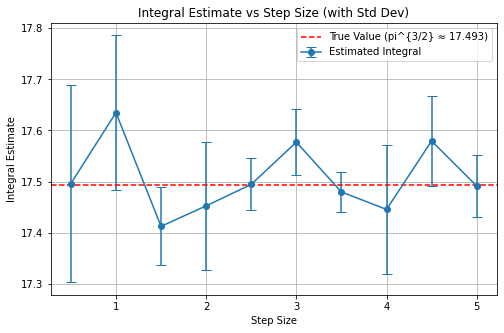

In [6]:
# Vary the step size, compute the integral multiple times for each, and show deviation from the true value
D = 5
N = 100_000
x0 = np.zeros(D)
thinning = 1
burnin = int(N * 0.1)
actual_value = np.pi ** (D/2)

step_sizes = np.linspace(0.5, 5.0, 10)
repeats = 5  # Number of runs per step size
means = []
stds = []

for step_size in step_sizes:
    estimates = []
    for _ in range(repeats):
        m_chain = gibbs_accept_reject(x0, thinning, burnin, N, step_size, target_pdf)
        estimate = importance_integration(f, target_pdf, m_chain)
        estimates.append(estimate)
    means.append(np.mean(estimates))
    stds.append(np.std(estimates))

plt.figure(figsize=(8, 5))
plt.errorbar(step_sizes, means, yerr=stds, fmt='o-', capsize=5, label='Estimated Integral')
plt.axhline(y=actual_value, color='red', linestyle='--', label=f'True Value (pi^{{3/2}} ≈ {actual_value:.3f})')
plt.xlabel('Step Size')
plt.ylabel('Integral Estimate')
plt.title('Integral Estimate vs Step Size (with Std Dev)')
plt.legend()
plt.grid(True)
plt.show()

You can change the value of `D` in the example usage cell to try different numbers of dimensions. The code will estimate the integral of exp(-sum(x**2)) over R^D using Gibbs sampling with accept-reject and importance sampling.